In [ ]:
from pandas import read_csv

from google.colab import drive
drive.mount('/content/MyDrive')

from re import sub

Drive already mounted at /content/MyDrive; to attempt to forcibly remount, call drive.mount("/content/MyDrive", force_remount=True).


In [ ]:
df = read_csv('/content/MyDrive/MyDrive/shortjokes.csv')
df.head()

,ID,Joke
0,1,"[me narrating a documentary about narrators] ""..."
1,2,Telling my daughter garlic is good for you. Go...
2,3,I've been going through a really rough period ...
3,4,"If I could have dinner with anyone, dead or al..."
4,5,Two guys walk into a bar. The third guy ducks.


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 231657 entries, 0 to 231656
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   ID      231657 non-null  int64 
 1   Joke    231657 non-null  object
dtypes: int64(1), object(1)
memory usage: 3.5+ MB


In [ ]:
def preprocess_text(text: str):
  res = text.lower()
  res = sub(r'\d+',     ' ', res) # remove digits  
  res = sub(r'[^a-z]',  ' ', res) # remove punctuation
  res = res.split()
  res = ' '.join(res)
  #res = ' '.join([word for word in res if not word in stop_word])
  return res

In [ ]:
X = df['Joke'].apply(preprocess_text)
X[:5]

0    me narrating a documentary about narrators i c...
1    telling my daughter garlic is good for you goo...
2    i ve been going through a really rough period ...
3    if i could have dinner with anyone dead or ali...
4         two guys walk into a bar the third guy ducks
Name: Joke, dtype: object

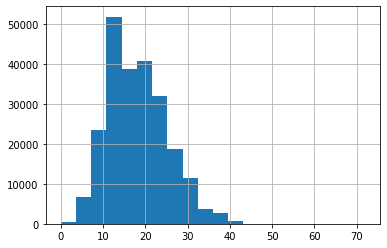

In [ ]:
X.apply(lambda x: len(x.split())).hist(bins=20)

(173442,)

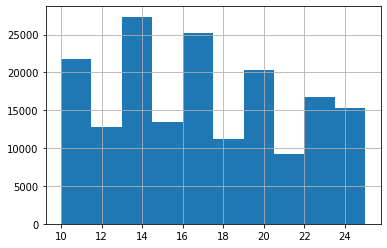

In [ ]:
lower=10
upper=25
df_words = X.str.split()
X = X[(df_words.apply(len)>=lower) & (df_words.apply(len)<=upper)].reset_index(drop=True)
X.apply(lambda x: len(x.split())).hist()
X.shape

In [ ]:
X[:5]

0    me narrating a documentary about narrators i c...
1    telling my daughter garlic is good for you goo...
2    i ve been going through a really rough period ...
3    if i could have dinner with anyone dead or ali...
4         two guys walk into a bar the third guy ducks
Name: Joke, dtype: object

keep most popular words

In [ ]:
from collections import Counter
import matplotlib.pyplot as plt

In [ ]:
counter = Counter(' '.join(X).split()).most_common()
counter[:10]

[('a', 120325),
 ('the', 109125),
 ('i', 79286),
 ('you', 62964),
 ('to', 59644),
 ('what', 42859),
 ('s', 40126),
 ('and', 38783),
 ('it', 38648),
 ('in', 36253)]

In [ ]:
threshold = 100
bag_of_words = [x[0] for x in counter if x[1]>=threshold]
len(bag_of_words)

2548

In [ ]:
import pandas as pd

In [ ]:
#jokes_oft = X[(X.str.split()).apply(lambda x: pd.Series(x).isin(bag_of_words).all())]
jokes_oft = X[X.apply(lambda x: pd.Series(x.split()).isin(bag_of_words).all())]

In [ ]:
jokes_oft.reset_index(drop=True, inplace=True)
jokes_oft[:5]

0         two guys walk into a bar the third guy ducks
1    you ever notice that the most dangerous thing ...
2    mom do you want this me no mom ok i ll give it...
3          a guy pick up a woman then he puts her down
4    did you hear about the midget psychic who esca...
Name: Joke, dtype: object

In [ ]:
class Vocab:
  def __init__(self, data):
    tokens = {'<sos>', '<eos>', '<unk>', '<pad>'}
    self.max_seq_len = 0
    for text in data:
      words = text.split()
      self.max_seq_len = max(self.max_seq_len, len(words) + 2) 
      tokens.update(words)

    self.idx_to_token = {idx: token for idx, token in enumerate(tokens)}
    self.token_to_idx = {token: idx for idx, token in self.idx_to_token.items()}

    self.vocab_len = len(self.idx_to_token)

In [ ]:
vocab = Vocab(jokes_oft)
vocab.vocab_len, vocab.max_seq_len

(2546, 27)

In [ ]:
from torch.utils.data import Dataset, DataLoader
from torch import tensor

In [ ]:
class JokeDataset(Dataset):
  def __init__(self, X, vocab: Vocab):
    self.X = X
    self.vocab = vocab

  def vectorize(self, text):
    words = text.split()
    vec = []
    vec.append(self.vocab.token_to_idx['<sos>'])

    for word in words:
      vec.append(self.vocab.token_to_idx.get(word,
                                             self.vocab.token_to_idx['<unk>']))
    vec.append(self.vocab.token_to_idx['<eos>'])

    while len(vec) < self.vocab.max_seq_len:
      vec.append(self.vocab.token_to_idx['<pad>'])

    return vec

  def __len__(self):
    return len(self.X)

  def __getitem__(self, idx):
    #X_vec = self.vectorize(self.X[idx][:self.vocab.max_seq_len])
    X_vec = self.vectorize(self.X[idx])
    y_vec = X_vec[1:] + [self.vocab.token_to_idx['<pad>']]
    return tensor(X_vec), tensor(y_vec)

In [ ]:
ds = JokeDataset(X, vocab)

In [ ]:
batch_size = 1000
dl = DataLoader(ds, batch_size=batch_size)

In [ ]:
from torch.nn import Module, Embedding, GRU, Linear, ReLU, CrossEntropyLoss
from torch.optim import Adam

In [ ]:
class Model(Module):

  def __init__(self, vol, emb, hid, bat, seq):
    super().__init__()
    self.vol = vol
    self.emb = emb
    self.hid = hid
    self.bat = bat
    self.seq = seq

    self.embedding = Embedding(vol, emb)
    self.gru = GRU(emb, hid,
                   num_layers = 1,
                   batch_first = True)
    self.dense = Linear(hid, vol)

  def forward(self, x, h):

    x = self.embedding(x)

    x, h = self.gru(x, h)

    x = x.reshape(-1, self.hid)

    x = self.dense(x)

    return x, h

In [ ]:
model = Model(vol = vocab.vocab_len,
              emb = 400,
              hid = 400,
              bat = batch_size,
              seq = vocab.max_seq_len)

loss = CrossEntropyLoss()
optimizer = Adam(model.parameters(),
                 lr=0.01)

In [ ]:
import torch
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)


cuda:0


In [ ]:
model.to(device)

Model(
  (embedding): Embedding(2546, 400)
  (gru): GRU(400, 400, batch_first=True)
  (dense): Linear(in_features=400, out_features=2546, bias=True)
)

In [ ]:
num_epochs = 40
mse = []
h = None
for epoch in range(num_epochs):
  loss_era = []
  for x, y in dl:
    x,y = x.to(device), y.to(device)
    out, hn = model(x, h)

    batch_loss = loss(out, y.reshape(-1))

    batch_loss.backward()
    
    optimizer.step()
    optimizer.zero_grad()
    
    loss_era.append(batch_loss.item())
  loss_era = sum(loss_era)/len(loss_era)
  print(f'epoch: {epoch}, loss: {round(loss_era, 4)}')
  mse.append(loss_era)

epoch: 0, loss: 2.745
epoch: 1, loss: 2.4345
epoch: 2, loss: 2.3642
epoch: 3, loss: 2.3249
epoch: 4, loss: 2.2983
epoch: 5, loss: 2.2803
epoch: 6, loss: 2.2667
epoch: 7, loss: 2.2572
epoch: 8, loss: 2.2498


In [ ]:
plt.plot(mse)
plt.grid()

In [ ]:
from torch import normal, argmax, no_grad, random
from  numpy.random import choice
from random import choices

In [ ]:
jokes_oft[jokes_oft.str.startswith('you never')].values

array(['you never know how strong you are until you have to move your furniture all alone',
       'you never realize how boring life is until someone asks you what you like to do for fun',
       'you never know what you ve got until you clean your room',
       'you never gotta worry about me cheating on you i might eat something that was yours but thats about it',
       'you never really know how many inches you re gonna get or how long it ll last snow maybe',
       'you never realize what have till its gone toilet paper is a good example of this',
       'you never told me you were vegan no one ever',
       'you never realize how much you love sleeping until you have to wake up in the morning',
       'you never realize what you have till its gone toilet paper is a good example'],
      dtype=object)

In [ ]:
def gen_joke(part = []):
  name = [vocab.token_to_idx['<sos>']] + \
         [vocab.token_to_idx.get(l, vocab.token_to_idx['<unk>']) for l in part]

  # начальное состояние скрытого слоя случайное, 
  # из-за чего становится возможна случайная генерация слов
  # при условии, что первое слово - метка начала строки
  h_t = normal(0,1, size = (1, 1, 400)).to(device)

  # состояние скрытого слоя обновляется,
  # на основе заданных первых слов текста
  for l in name[:-1]:
    with no_grad():
      token_dist, h_t = model(tensor([l]).reshape(1,-1).to(device), h_t)

  # на основе последних слова и состояния скрытого слоя
  # генерируются новые слово и состояние скрытого слоя 
  while True:
    with no_grad():
      token_dist, h_t = model(tensor([name[-1]]).reshape(1,-1).to(device), h_t)
      token_dist = token_dist.cpu()
      #print(a(token_dist).size())
      token = argmax(token_dist, dim = 1) # заменить аргмакс на выбор
      #print(len(token_dist[0,]))
      #print(token_dist[0,:]+token_dist[0,:].min())

      #token = choices(list(range(len(token_dist[0,:]))), weights=token_dist[0,:]+abs(token_dist[0,:].min()))

      #print(token)
      name += token.tolist()
      if  (name[-1] == vocab.token_to_idx['<eos>']) or \
          (len(name) > vocab.max_seq_len): break

  name = ' '.join(vocab.idx_to_token[x] for x in name)
  name = name.replace('<sos>', '')
  name = name.replace('<eos>', '')
  name = name.replace('<pad>', '')
  name = name.replace('<unk>', '?')
  return name

[gen_joke(['you', 'never']) for _ in range(3)]

[' you never wanna grow old ',
 ' you never hear me again ',
 ' you never have to remove the ? ? ']

no jokes from dataset - success


In [ ]:
gen_joke()

' congratulations if you re fat '